In [1]:
import pandas as pd
import numpy as np
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import CalendarFourier
from sklearn.linear_model import LinearRegression

import geopandas as gpd
import folium as fol
from geopy.geocoders import Nominatim

In [2]:
## this data set downloaded from https://www.kaggle.com/datasets/rasulmah/sri-lanka-weather-dataset/data

weather = pd.read_csv('data/SriLanka_Weather_Dataset.csv')
# weather.head()

In [3]:
cities = pd.DataFrame({'Cities' : weather.city.unique()})
cities
latitudes = []
longitudes = []
# cities.head()
for i in range(cities['Cities'].size):
    lat = weather.loc[weather['city'] == cities['Cities'].iloc[i]]['latitude'].iloc[0]
    long = weather.loc[weather['city'] == cities['Cities'].iloc[i]]['longitude'].iloc[0]
    latitudes.append(lat)
    longitudes.append(long)
cities['latitude'] = latitudes; cities['longitude'] = longitudes


In [4]:
m_1 = folium.Map(width = 800, height = 450, location=[7.877083,80.697917], tiles='openstreetmap', zoom_start=8, zoom_control=True,
               scrollWheelZoom=False,
               dragging=False)

    
for idx, row in cities.iterrows():
    folium.Circle(location = [row['latitude'], row['longitude']], 
                  radius = 2000, color='green'
                 ).add_child(folium.Popup(row['Cities'])).add_to(m_1)
# Display the map
m_1

In [5]:
cities = weather.city.unique()
# cities

In [6]:
# collecting data according to city_name
# all the city names that we have in our csv, can add as a city name and get data
# city names that im going to use here Colombo, Jaffna, Matara, Badulla
city_name = 'Badulla'
weather_sl_city = weather[weather['city'] == city_name]

#changing date format
def dateTime(row):
    new_time = pd.to_datetime(row.time)
    row['time'] = new_time
    return row

weatherDate = weather_sl_city.apply(dateTime, axis='columns')
#dropping unwanted, redundant columns
weather_city = weatherDate.drop(columns = ['country', 'temperature_2m_max', 'temperature_2m_min', 'sunrise', 'sunset','apparent_temperature_max','apparent_temperature_min','snowfall_sum', 'longitude', 'latitude', 'elevation'])
weather_city.set_index('time', drop = True, inplace = True)

<Axes: xlabel='month', ylabel='year'>

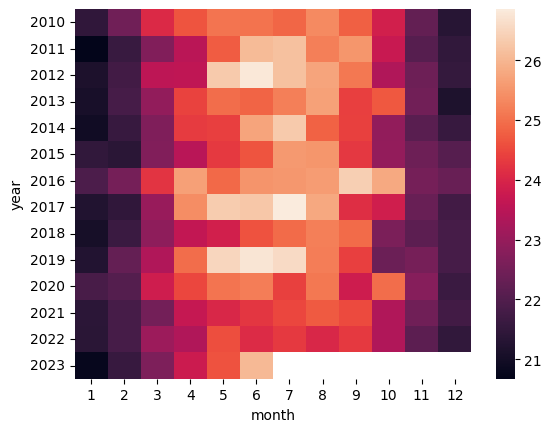

In [7]:
# get avarage template for year 2010 to 2023, for each month
avg_temp = weather_city.groupby([weather_city.index.year, weather_city.index.month]).aggregate(
{'apparent_temperature_mean' : 'mean', 'temperature_2m_mean' : 'mean'})
avg_temp.index.names = ['year', 'month']

avg_temp = avg_temp.reset_index()

# glue = avg_temp.pivot("year", "month", "temperature_2m_mean")
glue = avg_temp.pivot_table(index='year', columns='month', values='temperature_2m_mean')

sns.heatmap(glue)

Text(0, 0.5, 'Average Tmp')

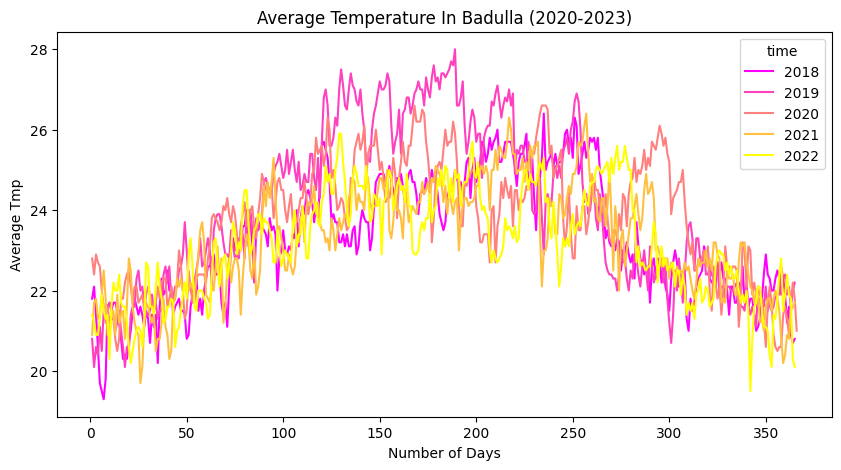

In [8]:
# get avarage template for year 2018 to 2023, for each month
T = weather_city.loc['2018-01-01':'2022-12-31']['temperature_2m_mean']
fig = plt.subplots(figsize=(10, 5))
palette = sns.color_palette("hls", 5)
sns.lineplot(x=T.index.dayofyear, 
             y=T, 
             hue=T.index.year,
            palette='spring');
plt.title('Average Temperature In '+city_name+' (2020-2023)')
plt.xlabel('Number of Days')
plt.ylabel('Average Tmp')

Text(0.5, 1.0, 'Each Month Rainfall for Badulla (2010 - 2022)')

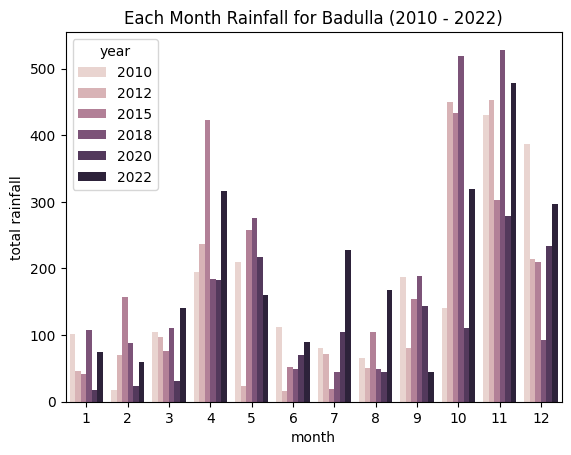

In [11]:
# get avarage Rainfall for year 2010 to 2022, for each month
annual_rainfall = weather_city.groupby([weather_city.index.year, weather_city.index.month]).rain_sum.sum()
annual_rainfall.index.names = ['year', 'month']

rainfall_series = annual_rainfall.loc[[2010, 2012, 2015, 2018, 2020, 2022]]
monthly_rainfall_by_year = pd.DataFrame({'total rainfall' : rainfall_series}).reset_index()

sns.barplot( x= 'month' , y = 'total rainfall', hue = 'year', data = monthly_rainfall_by_year)
plt.title('Each Month Rainfall for '+city_name+' (2010 - 2022)')

Text(0, 0.5, 'Total Rainfall')

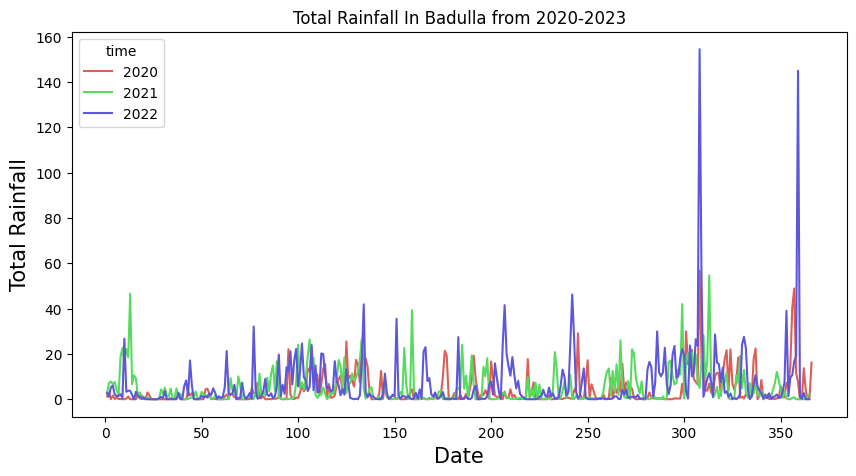

In [217]:
# get avarage Rainfall for year 2020 to 2022, for each month
R = weather_city.loc['2020-01-01':'2022-12-31']['rain_sum']
fig = plt.subplots(figsize=(10, 5))
palette = sns.color_palette("hls", 3)
sns.lineplot(x=R.index.dayofyear, 
             y=R, 
             hue=R.index.year,
            palette=palette,);
plt.title('Total Rainfall In '+city_name+' from 2020-2023')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Total Rainfall', fontsize=15)

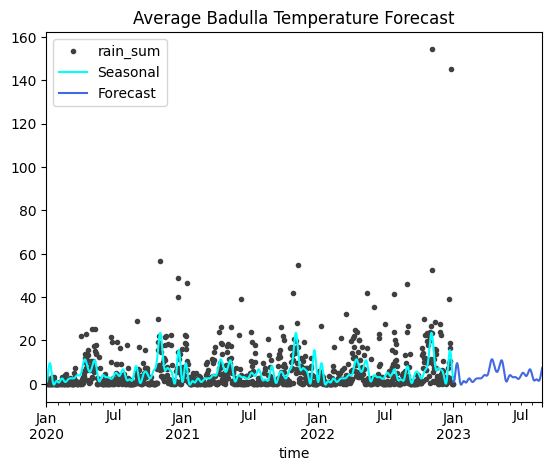

In [218]:
# seasonal forecasting using fourier features
fourier = CalendarFourier(freq="A", order=24) 
X = fourier.in_sample(R.index)
y = R
model = LinearRegression()
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = fourier.out_of_sample(steps = 240, index = pd.date_range("2020-01-01", "2022-12-31", freq="D"))
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Average "+city_name+" Temperature Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal", color = 'cyan')
ax = y_fore.plot(ax=ax, label="Forecast", color='royalblue')
_ = ax.legend()